In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import cache
import utils
wandb_api = wandb.Api()
%config InlineBackend.figure_format='retina'

In [2]:
# load runs
project = 'picodo-finetune'
sweeps = {
    'Adam, BS=1': utils.load_sweeps(['gemma4bpt_math_adam_bs1_v2'], project=project),
    'Adam, BS=16': utils.load_sweeps(['gemma4bpt_math_adam_bs16_v2'], project=project),
    'Adafactor, BS=1': utils.load_sweeps(['gemma4bpt_math_adafactor_v3', 'gemma4bpt_math_adafactor_v4'], project=project),
    'LoRA, BS=1': utils.load_sweeps(['gemma4bpt_math_lora_v2'], project=project),
}

len(sweeps)=1
len(sweeps)=1
len(sweeps)=2
len(sweeps)=1


Adam, BS=1 48
Adam, BS=16 48
Adafactor, BS=1 48
LoRA, BS=1 48


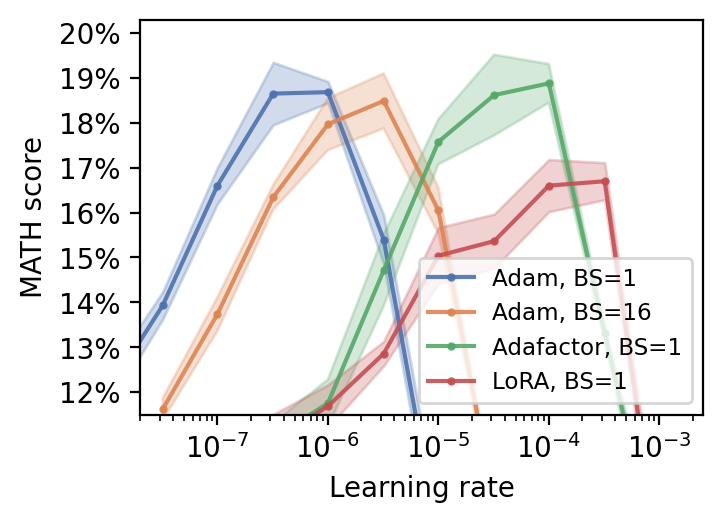

In [6]:
# for each sweep, plot LR vs loss (ensure we found optimal LR)
fig, ax = plt.subplots(figsize=(3.5, 2.5), layout='constrained')
colors = np.array(sns.color_palette('deep'))[[0, 1, 2, 3]]
# to_plot = np.array(list(sweeps.keys()))[[0, 1, 3, 2]]
for i, name in enumerate(sweeps.keys()):
    sweep = sweeps[name]
    print(name, len(sweep))
    # if name == 'adafactor': continue
    sweep = sweep[~sweep['accuracy'].isna()]
    x = np.array([float(x) for x in sweep['peak_lr']])
    y = sweep['accuracy'].values
    
    # o = np.argsort(lr)
    # ax.plot(x[o], y[o], '.-', label=name, alpha=0.5)

    x_unique = np.sort(np.unique(x))
    y = [y[x==u] for u in x_unique] # [-1, n_seeds]
    se = np.array([np.std(v)/np.sqrt(len(v)) for v in y])
    y_mean = np.array([np.mean(v) for v in y])
    y_min, y_max = y_mean-se, y_mean+se
    ax.plot(x_unique, y_mean, '.-', c=colors[i], label=name, ms=4, alpha=0.9)
    ax.fill_between(x_unique, y_min, y_max, color=colors[i], alpha=0.25)
    
ax.set_ylim([0.115, 0.203])
ax.set_xlim([2e-8, 2.5e-3])
ax.set_xscale('log')
ax.set_xlabel('Learning rate')
ax.set_ylabel('MATH score')
ax.set_yticks(np.arange(0.12, 0.201, 0.01))
ax.yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')
ax.legend(loc='lower right', prop={'size': 8.3})
# plt.savefig('plots/gemma_finetune.pdf')
plt.show()

In [7]:
# include memory info in plot
memory = {
    'Adam, BS=1': 3,
    'Adam, BS=16': 4,
    'Adafactor, BS=1': 1,
    'LoRA, BS=1': 1,
}

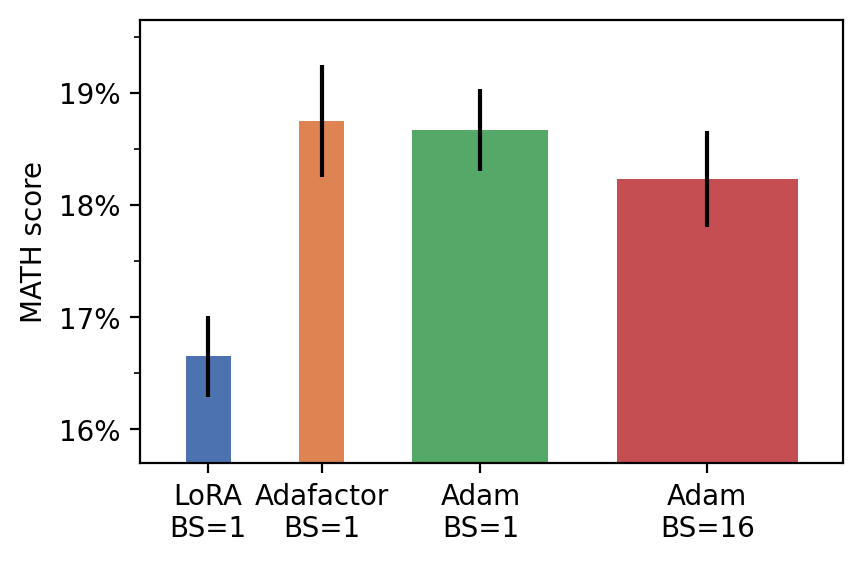

In [8]:
to_plot = ['LoRA, BS=1', 'Adafactor, BS=1', 'Adam, BS=1', 'Adam, BS=16']
means = []
ses = []
for i, name in enumerate(to_plot):
    sweep = sweeps[name]
    best_lrs = sweep.groupby('peak_lr').mean('accuracy')['accuracy'].sort_values().index.values[-2:]
    y = sweep[np.isin(sweep['peak_lr'], best_lrs)]['accuracy'].values
    means += [np.mean(y)]
    ses += [np.std(y) / np.sqrt(len(y))]

fig, ax = plt.subplots(figsize=(4.2, 2.7), layout='constrained')
x = [1, 1.5, 2.2, 3.2]
ax.bar(x, means, width=[0.2, 0.2, 0.6, 0.8], color=colors)
ax.errorbar(x, means, yerr=ses, ls='none', color='black')
ax.yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')
ax.set_ylim([0.157, 0.1965])
ax.set_yticks([0.16, 0.17, 0.18, 0.19])
ax.set_yticks([0.165, 0.175, 0.185, 0.195], ['' for i in range(4)], minor=True)
ax.set_xlim([0.7, 3.8])
# ax.set_xticks(x, to_plot, rotation=14)
ax.set_xticks(x, [name.replace(', ', '\n') for name in to_plot], rotation=0)
ax.set_ylabel('MATH score')
# plt.savefig('plots/finetune_barplot.pdf')
# ax.set_title('Gemma 3 (4B) fine-tuning')
plt.show()